# Song Recommendation With Multi-Task Learning

## Dataset Overview

### Dataset Feature Format and Multi-Task Explanation

For this assignment I am using a Spotify song dataset. This dataset contains songs from approximatesly 10,000 playlists. Features and metadata about the songs are obtained using Spotify API. Features include danceablilty. liveness, key, mode (major or minor), speechiness, acousticness, instrumentalness, liveness, and valence (happy or sad). Metadata about the songs include song name, artist name, artist genre, artist popularity, and song popularity. For my purposes I am only using song features and genres to train my model. This sums to a total of 11 feaure vectors and 1 genre per song. Spotify provides a list of genres that pertain to a given artist, however I only use the first genre in the list since it is the most prominent. Since there are about 1300 genres, I will be aggregating each song into 1 of 26 genre groups. <br><br>

After aggregating the songs into genre groups, I create a latent space of 12 dimensions with a Variational Autoencoder (VAE). I use a VAE so my latent space exhibits smoothness and distances between points in the latent space are meaningful.<br><br>

Once I have plotted my songs in the latent space, I create a list of genre groups for 3 different activities: exercising, relaxing and commuting. I chose genres with higher energy for exercise, lower energy for relaxing and genres in-between for commuting. Multiple genres can exist in multiple different activity lists.<br><br>

I use these genres to simulate user preferences for different activities. While this can scale to generating many different users, I am using 3 in this study. To generate a user, I randomly choose 1 genre from each activity list to represent their preferences. I then calculate the location of the centroid of the given genres in the latent space. All songs that fall within 1 standard of deviation away from this centroid represent a song that the user would like for that activity these songs can span outside of the given genre. I then introduce randomness by randomly removing 10% of the songs within the centroid radius and adding an equivalent number of song from outside of the radius to the preferences. This randomness is to better simulate a real human's tastes. After I assign the user preferences to each song, my dataset is ready for multi-task learning.<br><br>

The classification task at hand is to predict whether or not a user would listen to a given song for each activity. It is possible for a user to like one song for multiple activities. This is a multi-task learning problem where predicting preferences for each user is an individual task. I am using 3 users so I have 3 tasks.<br><br>

### Source of Data

This data was originallly released as a part of the [Spotify Million Playlist Dataset challenge](https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge)  from AICrowd. This data was released as an AI challenge for creating and experimenting with music recommendation models. The dataset released by AICrowd is in JSON format with limited information about each song including name and ID. In order to retrieve metadata and features about each song, one must iterate through the JSON files and use Spotify's API calls.<br><br>

This process is extremely time consuming as the dataset is huge and Spotify API throttles the number of API calls that can be made per second. The dataset I'm using was retrieved by Eric Chang for use in an [educational medium article](https://towardsdatascience.com/part-iii-building-a-song-recommendation-system-with-spotify-cf76b52705e7) walking through basic music recommendation in python. The authors open-sourced the data on GitHub. The dataset contains features and metadata retrieved from a subset of 10,000 playlists of the original dataset. 

### Evaluation Criteria

My learning task is multiple binary classification. My model will output three units, each will represent whether or not the user would listen to the given song for each activity. For evaluating this model I will be using an AUC score for each individual activity or each individual user as it represents how well a model can distinguish between positive and negative classes ini binary classification. I will visualize these evauluations using an AUC-ROC curve. I will compare the performance on each task between users and the general model. I will also aggregate the predictions over all users in the multi-task model and evaluate with an AUC score.<br><br>

Since the majority of the songs in my dataset are not within the preferences of each user, I am using balanced class weighting to avoid a bias toward always classifying the song as false for all activities.



## Loading Data and Preprocessing

In [1]:
import pandas as pd
import numpy as np
import ast
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np
import tensorflow as tf
import tensorflow.keras
import keras
from tensorflow.keras import layers
from keras.models import Sequential
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import plotly.io as plt_io
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
import itertools
from sklearn.utils import class_weight
from tensorflow.keras.models import Model
import random
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, auc, classification_report
%matplotlib inline

In [2]:
songs_df = pd.read_csv('data/cleaned_songs.csv')
songs_df

,artist_name,id,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist_pop,genres,track_pop,genres_list,subjectivity,polarity
0,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),0.904,0.813,4,-7.105,0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,74,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...,69,"['dance_pop', 'hip_hop', 'hip_pop', 'pop', 'po...",low,Neutral
1,Britney Spears,6I9VzXrHxO9rA9A5euc8Ak,Toxic,0.774,0.838,5,-3.914,0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,84,dance_pop pop post-teen_pop,83,"['dance_pop', 'pop', 'post-teen_pop']",low,Neutral
2,Beyoncé,0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,0.664,0.758,2,-6.583,0,0.2100,0.00238,0.000000,0.0598,0.701,99.259,86,dance_pop pop r&b,25,"['dance_pop', 'pop', 'r&b']",high,Negative
3,Justin Timberlake,1AWQoqb9bSvzTjaLralEkT,Rock Your Body,0.892,0.714,4,-6.055,0,0.1410,0.20100,0.000234,0.0521,0.817,100.972,82,dance_pop pop,79,"['dance_pop', 'pop']",low,Neutral
4,Shaggy,1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,0.853,0.606,0,-4.596,1,0.0713,0.05610,0.000000,0.3130,0.654,94.759,75,pop_rap reggae_fusion,2,"['pop_rap', 'reggae_fusion']",low,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34242,Jon D,3uCHI1gfOUL5j5swEh0TcH,I Don't Know,0.669,0.228,2,-12.119,1,0.0690,0.79200,0.065000,0.0944,0.402,83.024,47,unknown,27,['unknown'],low,Neutral
34243,Big Words,0P1oO2gREMYUCoOkzYAyFu,The Answer,0.493,0.727,1,-5.031,1,0.2170,0.08730,0.000000,0.1290,0.289,73.259,39,australian_r&b,37,['australian_r&b'],low,Neutral
34244,Allan Rayman,2oM4BuruDnEvk59IvIXCwn,25.22,0.702,0.524,7,-10.710,1,0.0793,0.33200,0.055300,0.2980,0.265,140.089,55,canadian_contemporary_r&b modern_alternative_rock,49,"['canadian_contemporary_r&b', 'modern_alternat...",low,Neutral
34245,Jon Jason,4Ri5TTUgjM96tbQZd5Ua7V,Good Feeling,0.509,0.286,8,-14.722,1,0.1230,0.40200,0.000012,0.1310,0.259,121.633,4,unknown,16,['unknown'],high,Positive


In [3]:
# drop rows with identical artist_name and track_name
songs_df = songs_df.drop_duplicates(subset=['artist_name', 'track_name'], keep='first')
#add column with the first item in the genres list
songs_df['genre'] = songs_df['genres_list'].apply(lambda x: ast.literal_eval(x)[0])
#drop subjectivity, polarity, genres, genre list and identifiers
songs_df = songs_df.drop(columns=['subjectivity', 'polarity', 'genres', 'genres_list', 'track_name', 'artist_name', 'id'])
#drop rows with unknown genre
songs_df = songs_df[songs_df['genre'] != 'unknown']
songs_df.head(25)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist_pop,track_pop,genre
0,0.904,0.813,4,-7.105,0,0.1210,0.031100,0.006970,0.0471,0.810,125.461,74,69,dance_pop
1,0.774,0.838,5,-3.914,0,0.1140,0.024900,0.025000,0.2420,0.924,143.040,84,83,dance_pop
2,0.664,0.758,2,-6.583,0,0.2100,0.002380,0.000000,0.0598,0.701,99.259,86,25,dance_pop
3,0.892,0.714,4,-6.055,0,0.1410,0.201000,0.000234,0.0521,0.817,100.972,82,79,dance_pop
4,0.853,0.606,0,-4.596,1,0.0713,0.056100,0.000000,0.3130,0.654,94.759,75,2,pop_rap
5,0.881,0.788,2,-4.669,1,0.1680,0.021200,0.000000,0.0377,0.592,104.997,82,0,atl_hip_hop
6,0.662,0.507,5,-8.238,1,0.1180,0.257000,0.000000,0.0465,0.676,86.412,82,79,atl_hip_hop
7,0.570,0.821,2,-4.380,1,0.2670,0.178000,0.000000,0.2890,0.408,210.857,72,67,dance_pop
8,0.713,0.678,5,-3.525,0,0.1020,0.273000,0.000000,0.1490,0.734,138.009,75,78,dance_pop
9,0.727,0.974,4,-2.261,0,0.0664,0.103000,0.000532,0.1740,0.965,79.526,77,82,atl_hip_hop


In [4]:
songs_df.genre.value_counts()

dance_pop               2515
contemporary_country    1595
alternative_metal       1032
album_rock               729
atl_hip_hop              726
                        ... 
viral_rap                  1
azontobeats                1
victoria_bc_indie          1
cello                      1
jazz_guitar                1
Name: genre, Length: 1298, dtype: int64

### Aggregating Genres into Genre Groups

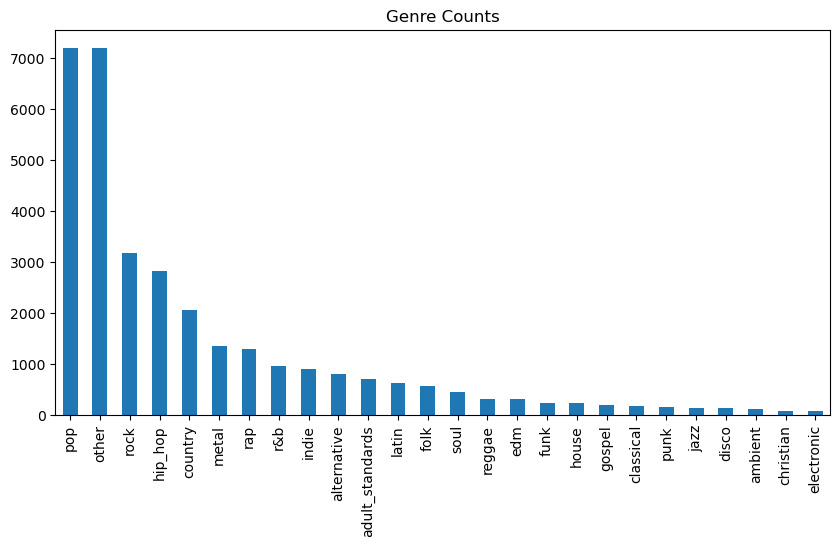

0.2234472049689441
26


In [5]:
#create empty list of length of the dataframe
genre_group = np.empty((len(songs_df), 1)).tolist()
others = []

#add a column that groups genres into categories being pop, rock, hip hop, metal, country, rap, r&b, edm, jazz, soul, blues, reggae, classical, folk
for i, genre in enumerate(songs_df['genre']):

    if 'pop' in genre:
        genre_group[i] = 'pop'
    elif 'rock' in genre:
        genre_group[i] = 'rock'
    elif 'hip_hop' in genre:
        genre_group[i] = 'hip_hop'
    elif 'country' in genre:
        genre_group[i] = 'country'
    elif 'rap' in genre:
        genre_group[i] = 'rap'
    elif 'r&b' in genre:
        genre_group[i] = 'r&b'
    elif 'edm' in genre:
        genre_group[i] = 'edm'
    elif 'jazz' in genre:
        genre_group[i] = 'jazz'
    elif 'soul' in genre:
        genre_group[i] = 'soul'
    elif 'reggae' in genre:
        genre_group[i] = 'reggae'
    elif 'classical' in genre:
        genre_group[i] = 'classical'
    elif 'folk' in genre:
        genre_group[i] = 'folk'
    elif 'metal' in genre:
        genre_group[i] = 'metal'
    elif 'latin' in genre:
        genre_group[i] = 'latin'
    elif 'christian' in genre:
        genre_group[i] = 'christian'
    elif 'gospel' in genre:
        genre_group[i] = 'gospel'
    elif 'indie' in genre:
        genre_group[i] = 'indie'
    elif 'electronic' in genre:
        genre_group[i] = 'electronic'
    elif 'disco' in genre:
        genre_group[i] = 'disco'
    elif 'punk' in genre:
        genre_group[i] = 'punk'
    elif 'funk' in genre:
        genre_group[i] = 'funk'
    elif 'alternative' in genre:
        genre_group[i] = 'alternative'
    elif 'ambient' in genre:
        genre_group[i] = 'ambient'
    elif 'house' in genre:
        genre_group[i] = 'house'
    elif 'adult_standards' in genre:
        genre_group[i] = 'adult_standards'
    else:
        genre_group[i] = 'other'
        others.append(genre)


#make a dictionaty to ttranslate tthese things dict reanslatte what to what

        
#print the value counts of the genres in a grid
pd.Series(genre_group).value_counts().plot(kind='bar', figsize=(10, 5), title='Genre Counts')
plt.show()
#find the number of items in the 'other' category
other_count = pd.Series(genre_group).value_counts()['other']
#divide the number of items in the 'other' category by the total number of items
print(other_count / len(songs_df))
#find the number of unique genres
print(len(pd.Series(genre_group).value_counts()))

In [6]:
#print the names of the genre groups
print(pd.Series(genre_group).value_counts())

pop                7198
other              7195
rock               3181
hip_hop            2821
country            2054
metal              1346
rap                1284
r&b                 963
indie               902
alternative         806
adult_standards     709
latin               627
folk                569
soul                439
reggae              312
edm                 311
funk                236
house               223
gospel              186
classical           173
punk                151
jazz                136
disco               130
ambient             117
christian            69
electronic           62
dtype: int64


In [7]:
#add the genre_group column to the dataframe
songs_df['genre_group'] = genre_group
#drop the genre column
songs_df = songs_df.drop(columns=['genre'])

## Creating Variational Autoencoder (VAE)

Intuition behind VAE: https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73

A variational autoencoder (VAE) is a generative model consisting of an encoder and a decoder. The encoder learns to map data from a high-dimensional input space to a low-dimensional latent space, and the corresponding decoder maps the latent space back to the input space. Unlike traditional autoencoders, VAEs uses variational inference to force a regularized distribution on the latent space. This is done so by modifying the loss function to include a KL divergence term. The KL divergence term is a measure of how different the latent space distribution is from a standard normal distribution. The KL divergence term is minimized by the VAE so the latent space distribution is as close to a standard normal distribution as possible. This is done so the latent space is smooth and distances between points in the latent space are meaningful. The VAE is trained by minimizing the sum of the reconstruction loss and the KL divergence term. In the simplest methods, the reconstruction loss is defined by either mean squared error or binary cross entropy.

In [8]:
from tensorflow.keras import losses

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # reconstruction_loss = tf.reduce_mean(
            #     tf.reduce_sum(
            #         keras.losses.mean_squared_error(data, reconstruction), axis=None
            #     )
            # )
            reconstruction_loss = losses.binary_crossentropy(data, reconstruction)
            #experiment with assing a lambda value to the kl_loss
            kl_loss = (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = -5e-4 * tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(z_log_var) * epsilon

Before creating my embedding, I will perform a train test split on my data. This way I can evaluate my VAE and oveall model with songs that were not included in embedding matrix.

In [9]:
#split the data into train and test with genre_group as the the label
X_train_embedding, X_test_embedding, y_train_embedding, y_test_embedding = train_test_split(songs_df.drop(columns=['genre_group']), songs_df['genre_group'], test_size=0.2, random_state=42, stratify=songs_df['genre_group'])

#preprocessing first
ohe = OneHotEncoder()
scaler = StandardScaler()

#separate into numberical and categorical features
X_train_embedding_num = X_train_embedding.drop(columns=['key', 'mode'])

X_test_embedding_num = X_test_embedding.drop(columns=['key', 'mode'])

#one-hot encode the key label
train_key = ohe.fit_transform(X_train_embedding['key'].values.reshape(-1, 1)).toarray()
test_key = ohe.transform(X_test_embedding['key'].values.reshape(-1, 1)).toarray()

train_mode = X_train_embedding['mode'].values.reshape(-1, 1)
test_mode = X_test_embedding['mode'].values.reshape(-1, 1)

#creating categorical dataframe which combines the one-hot encoded key and the mode
X_train_embedding_cat = np.concatenate((train_key,train_mode), axis=1)
X_test_embedding_cat = np.concatenate((test_key,test_mode), axis=1)

#standardizing the numerical features
X_train_embedding_num = scaler.fit_transform(X_train_embedding_num)
X_test_embedding_num = scaler.transform(X_test_embedding_num)

#concatenate the one-hot encoded key and the numerical features
X_train_embedding = np.concatenate((X_train_embedding_num, X_train_embedding_cat), axis=1)
X_test_embedding = np.concatenate((X_test_embedding_num, X_test_embedding_cat), axis=1)

#print train and test shapes
print(X_train_embedding.shape)
print(X_test_embedding.shape)


(25760, 24)
(6440, 24)


In [10]:
#print the ttrain embedding using pandas
pd.DataFrame(X_train_embedding).head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,-0.240350,-0.637297,0.386088,-0.626879,0.967848,-0.344560,-0.491509,-1.034563,0.186780,-0.856993,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.258699,0.716684,1.011443,0.608338,-0.461782,-0.344536,1.795165,0.200241,-1.016544,-1.157097,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.093555,0.546878,0.869877,-0.332827,-0.580526,-0.344549,-0.621665,-0.236056,0.966341,-0.016701,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.882062,0.265357,0.136358,1.631130,-0.323865,-0.344560,3.419121,1.076952,-0.264462,-1.097076,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.540057,-0.449617,0.533306,0.372310,0.234532,-0.344560,-0.013875,0.846455,-0.010696,-0.676931,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Encoder

In [11]:
latent_dim = 12

encoder_inputs = keras.Input(shape=(X_train_embedding.shape[1],))
x =layers.Dense(19, activation="relu")(encoder_inputs)
x = layers.Dense(15, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 24)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 19)           475         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 15)           300         ['dense[0][0]']                  
                                                                                                  
 z_mean (Dense)                 (None, 12)           192         ['dense_1[0][0]']                
                                                                                            

2023-04-22 16:18:10.340561: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Decoder

In [12]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(15, activation="relu")(latent_inputs)
x = layers.Dense(19, activation="relu")(x)
decoder_outputs = layers.Dense(X_train_embedding.shape[1], activation="tanh")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense_2 (Dense)             (None, 15)                195       
                                                                 
 dense_3 (Dense)             (None, 19)                304       
                                                                 
 dense_4 (Dense)             (None, 24)                480       
                                                                 
Total params: 979
Trainable params: 979
Non-trainable params: 0
_________________________________________________________________


### VAE Training

In [13]:
# instantiate and run the VAE model
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(X_train_embedding, epochs=100, batch_size=32, shuffle=True)


Epoch 1/100
805/805 [==============================] - 1s 1ms/step - loss: 0.4123 - reconstruction_loss: 0.1931 - kl_loss: 0.0023
Epoch 2/100
805/805 [==============================] - 1s 1ms/step - loss: -0.3450 - reconstruction_loss: -0.4373 - kl_loss: 0.0062
Epoch 3/100
805/805 [==============================] - 1s 970us/step - loss: -0.5378 - reconstruction_loss: -0.6356 - kl_loss: 0.0089
Epoch 4/100
805/805 [==============================] - 1s 964us/step - loss: -0.8006 - reconstruction_loss: -0.8238 - kl_loss: 0.0141
Epoch 5/100
805/805 [==============================] - 1s 967us/step - loss: -0.8690 - reconstruction_loss: -0.9225 - kl_loss: 0.0151
Epoch 6/100
805/805 [==============================] - 1s 971us/step - loss: -1.0138 - reconstruction_loss: -1.0307 - kl_loss: 0.0163
Epoch 7/100
805/805 [==============================] - 1s 1ms/step - loss: -1.0894 - reconstruction_loss: -1.1624 - kl_loss: 0.0198
Epoch 8/100
805/805 [==============================] - 1s 961us/step -

Text(0, 0.5, 'Loss')

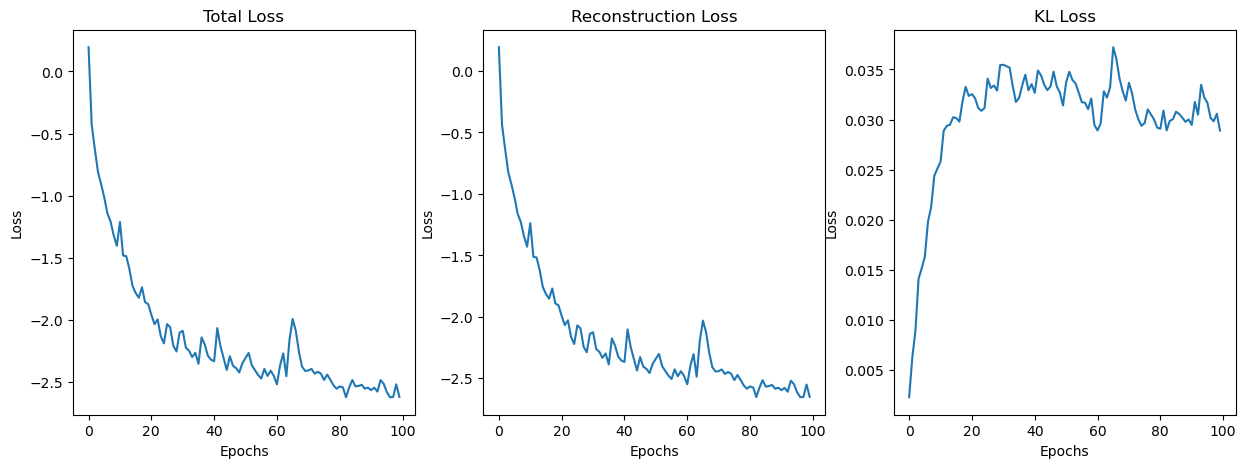

In [14]:
#plot the loss, reconstruction loss, and KL loss 3 in separate plots side by side
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(vae.history.history['loss'])
plt.title('Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 3, 2)
plt.plot(vae.history.history['reconstruction_loss'])
plt.title('Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 3, 3)
plt.plot(vae.history.history['kl_loss'])
plt.title('KL Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [15]:
latent_space, _, _ = encoder.predict(X_train_embedding)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(latent_space)

# Convert the data to a pandas DataFrame
df = pd.DataFrame({'pca0': X_train_pca[:, 0], 'pca1': X_train_pca[:, 1], 'genre_group': y_train_embedding})

# Create a scatter plot using Plotly
fig = px.scatter(df, x='pca0', y='pca1', color='genre_group')

# Add labels and adjust the layout
fig.update_layout(
    title='PCA Latent Space Visualization',
    xaxis_title='pca0',
    yaxis_title='pca1',
    legend_title='Genre Group'
)

# Display the plot
fig.show()

805/805 [==============================] - 1s 1ms/step


Text(0, 0.5, 'cumulative explained variance')

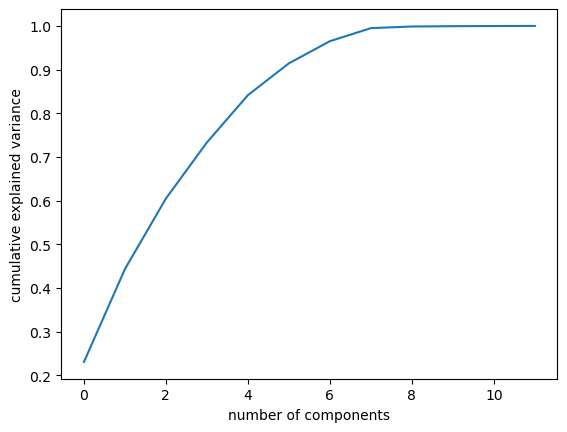

In [16]:
# create a scree plot to see how many components to keep
pca = PCA()
pca.fit(latent_space)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')



Scree plot to visualize the variance explained by each latent dimension, this is a good way to determine the number of latent dimensions to use.



### Creating List of Genres for each Activity

In [17]:
# a list of genre groups for exercising
exercise_genres = ['pop', 'rock', 'hip_hop', 'metal', 'rap', 'edm', 'electronic', 'house', 'punk']
# a list of genre groups for relaxing
relax_genres = ['r&b', 'adult_standards', 'soul', 'reggae', 'classical', 'jazz', 'ambient']
# a list of genre groups for commmuting
commute_genres = ['pop', 'rock', 'country', 'hip_hop', 'funk', 'latin', 'disco', 'folk', 'rap']

### Calculating Genre Centroids

In [18]:
#a function that finds the centroid of a genre group in the latent space
def find_centroid(genre_group):
    #get the index of each song in the genre group
    genre_group_index = np.where(y_train_embedding == genre_group)[0]
    #get the latent space of the genre group
    #print(genre_group_index.shape)
    genre_group_latent_space = latent_space[genre_group_index, :]
    #find the centroid of the genre group
    centroid = np.mean(genre_group_latent_space, axis=0)
    #find the standard deviation of the genre group
    std = np.std(genre_group_latent_space, axis=0)
    #return the centroid and standard deviation
    return centroid, std

#find the centroid of each genre groups above and store them in a dictionary
exercise_centroids = np.array([find_centroid(genre) for genre in exercise_genres])
relax_centroids = np.array([find_centroid(genre) for genre in relax_genres])
commute_centroids = np.array([find_centroid(genre) for genre in commute_genres])

#combine the centroids into a single array with their original lists as labels
centroids = np.concatenate((exercise_centroids, relax_centroids, commute_centroids), axis=0)
activity_labels = ['exercise'] * len(exercise_centroids) + ['relax'] * len(relax_centroids) + ['commute'] * len(commute_centroids)
genre_group_labels = exercise_genres + relax_genres + commute_genres
centroids.shape



(25, 2, 12)

In [19]:
pca_1 = PCA(n_components=2)
centroid_pca = pca_1.fit_transform(centroids[:, 0, :])

# Convert the data to a pandas DataFrame
df_centroid_genre = pd.DataFrame({'pca0': centroid_pca[:, 0], 'pca1': centroid_pca[:, 1], 'genre_group': genre_group_labels})

# Create a scatter plot using Plotly
fig = px.scatter(df_centroid_genre, x='pca0', y='pca1', color='genre_group')

# Add labels and adjust the layout
fig.update_layout(
    title='PCA Genre Group Centroid Visualization',
    xaxis_title='pca0',
    yaxis_title='pca1',
    legend_title='genre_group'
)

# Display the plot
fig.show()

In [20]:
# Convert the data to a pandas DataFrame
df_centroid_activity = pd.DataFrame({'pca0': centroid_pca[:, 0], 'pca1': centroid_pca[:, 1], 'activity': activity_labels})

# Create a scatter plot using Plotly
fig = px.scatter(df_centroid_activity, x='pca0', y='pca1', color='activity')

# Add labels and adjust the layout
fig.update_layout(
    title='PCA Activity Centroid Visualization',
    xaxis_title='pca0',
    yaxis_title='pca1',
    legend_title='Activity'
)

# Display the plot
fig.show()

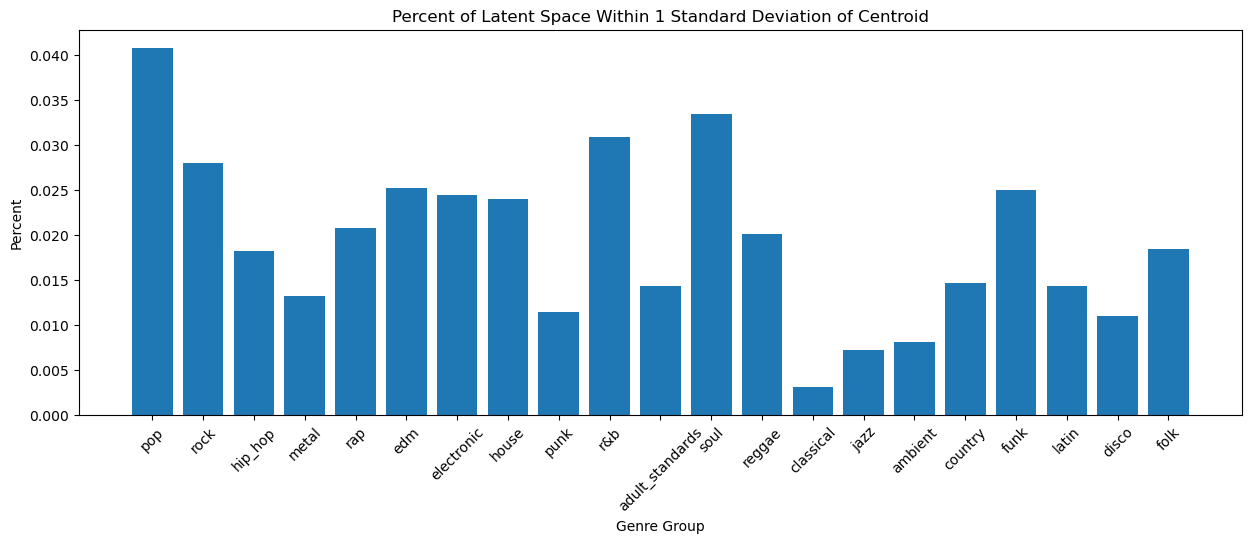

In [21]:
in_stds = []
#print the number of elements in the latents space that fall within 1 standard deviation of the centroid of each genre group
for i in range(len(centroids)):
    #get the centroid and standard deviation of the genre group
    centroid = centroids[i, 0, :]
    std = centroids[i, 1, :]
    #find the number of elements in the latent space that fall within 1 standard deviation of the centroid
    in_std = np.sum(np.sum(np.abs(latent_space - centroid) < std, axis=1) == latent_dim)
    in_stds.append(in_std)


in_std_percents = np.array(in_stds) / latent_space.shape[0] 
#plot the percents
plt.figure(figsize=(15, 5))
plt.bar(genre_group_labels, in_std_percents)
plt.xticks(rotation=45)
plt.title('Percent of Latent Space Within 1 Standard Deviation of Centroid')
plt.xlabel('Genre Group')
plt.ylabel('Percent')
plt.show()



### Generating Users

In [22]:
def create_users(num_users = 3, randomness_percent = 0.1, centroid_radius = 1, random_radius = None):
    #create a list will all possible combinations for the genre groups in the exercise, relax, and commute categories
    combinations = list(itertools.product(exercise_genres, relax_genres, commute_genres))

    #create an empty dataframe to store the user data
    users_df = pd.DataFrame()
    for user in range(num_users):
        #get a random combination of genre groups and remove it from the list of combinations
        exercise_genre, relax_genre, commute_genre = combinations.pop(np.random.randint(len(combinations)))

        #get all of the songs in the latent space that are 1 standard deviation away from the centroid of the exercise genre
        exercise_centroid = exercise_centroids[exercise_genres.index(exercise_genre), 0, :]
        exercise_std = exercise_centroids[exercise_genres.index(exercise_genre), 1, :]
        exercise_index = np.where(np.sum(np.abs(latent_space - exercise_centroid) < exercise_std*centroid_radius, axis=1) == latent_dim)[0]

        #get all of the songs in the latent space that are 1 standard deviation away from the centroid of the relax genre
        relax_centroid = relax_centroids[relax_genres.index(relax_genre), 0, :]
        relax_std = relax_centroids[relax_genres.index(relax_genre), 1, :]
        relax_index = np.where(np.sum(np.abs(latent_space - relax_centroid) < relax_std*centroid_radius, axis=1) == latent_dim)[0]

        #get all of the songs in the latent space that are 1 standard deviation away from the centroid of the commute genre
        commute_centroid = commute_centroids[commute_genres.index(commute_genre), 0, :]
        commute_std = commute_centroids[commute_genres.index(commute_genre), 1, :]
        commute_index = np.where(np.sum(np.abs(latent_space - commute_centroid) < commute_std*centroid_radius, axis=1) == latent_dim)[0]

        #convert the latent space to a dataframe
        user_df = pd.DataFrame(latent_space)
        user_df['user'] = user
        user_df['exercise'] = 0
        user_df['relax'] = 0
        user_df['commute'] = 0
        
        #set the exercise column to 1 for all of the songs in the exercise genre
        user_df.loc[exercise_index, 'exercise'] = 1
        #set the relax column to 1 for all of the songs in the relax genre
        user_df.loc[relax_index, 'relax'] = 1
        #set the commute column to 1 for all of the songs in the commute genre
        user_df.loc[commute_index, 'commute'] = 1

        #dict to store activity centroids and standard deviations
        activity_centroids = {'exercise': exercise_centroid, 'relax': relax_centroid, 'commute': commute_centroid}
        activity_stds = {'exercise': exercise_std, 'relax': relax_std, 'commute': commute_std}

        #add some randomness to the data
        #randomly select a percentage of the songs in each genre and switch the activity column
        for activity in ['exercise', 'relax', 'commute']:
            #get the index of the songs in the genre
            genre_index = user_df[user_df[activity] == 1].index
            not_genre_index = user_df[user_df[activity] == 0].index

            if random_radius:
                #get the index of the songs in the latent space that are within the random radius of the centroid
                random_index = np.where(np.sum(np.abs(latent_space - activity_centroids[activity]) < activity_stds[activity]*random_radius, axis=1) == latent_dim)[0]
                #get the index of the songs that are in the genre and within the random radius
                not_genre_index = np.intersect1d(not_genre_index, random_index)


            #get the number of songs to switch
            num_switch = int(len(genre_index) * randomness_percent)
            #get the index of the songs to switch


            switch_index_off = np.random.choice(genre_index, num_switch, replace=False)
            switch_index_on = np.random.choice(not_genre_index, num_switch, replace=False)
            #switch the activity column
            user_df.loc[switch_index_off, activity] = 0
            user_df.loc[switch_index_on, activity] = 1
            #switch the activity column for the other two activities

        #add the user dataframe to the overall dataframe
        if user == 0:
            users_df = user_df
        else:
            users_df = pd.concat([users_df, user_df], axis=0)

    return users_df

In [23]:
users_data = create_users(num_users=3, randomness_percent=0.1, centroid_radius=1, random_radius=None)
users_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,user,exercise,relax,commute
0,0.306826,-0.770038,-0.382733,-0.789622,-0.637516,0.816120,0.671193,-1.193909,0.137937,-0.199856,-0.178573,0.084342,0,0,0,0
1,0.252397,2.181939,-1.158305,0.404378,-1.435527,1.232860,0.043267,3.661533,-0.856132,0.590296,-0.532474,1.998194,0,0,0,0
2,-0.399935,0.706309,0.220381,0.775744,0.118900,0.938098,-1.973868,-0.183656,0.514467,0.244139,-1.785830,0.639727,0,0,0,0
3,2.044566,2.610923,-1.473404,-0.793080,-2.416543,-0.694298,1.384062,6.121675,-0.219981,0.775259,2.088196,1.723756,0,0,0,0
4,1.594063,0.817521,-0.287690,-1.464800,-1.288823,0.484788,0.326023,0.529396,0.720782,0.776448,-1.496886,0.119744,0,0,0,0


In [24]:
#print the percent of songs with a 0 for all three activity columns per user
for user in users_data['user'].unique():
    print('User {} has {}% of songs with 0 for all three activity columns'.format(user, round(np.sum((users_data['user'] == user) 
                                                                                                     & (users_data['exercise'] == 0) 
                                                                                                     & (users_data['relax'] == 0) 
                                                                                                     & (users_data['commute'] == 0)) 
                                                                                                     / len(users_data[users_data['user'] == user]) * 100, 2)))

User 0 has 93.72% of songs with 0 for all three activity columns
User 1 has 94.71% of songs with 0 for all three activity columns
User 2 has 94.83% of songs with 0 for all three activity columns


## Train-Test Split

When I split the data, I am stratifying by each task and each activity so that there is a propotiaonally equal amount of data for each user and activity in both the training and test sets. I think it is crucial that I am stratifying be user so the model is not biased towards the preferences of any one user. If a given user is over-represented in the training data, this bias is probable. I am also stratifying between activity so that the model can accurately predict preferences for each activity. If a given activity is over represented it is possible that the model will bias predictions towards this activity.

In [25]:
#train test split with validation set
X = users_data.drop(columns=['exercise', 'relax', 'commute'])
y = users_data[['user', 'exercise', 'relax', 'commute']]

# split the data into training and test sets with stratification over user, exercise, relax, and commute
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=users_data[['user', 'exercise', 'relax', 'commute']])

# print the shape of the resulting sets
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

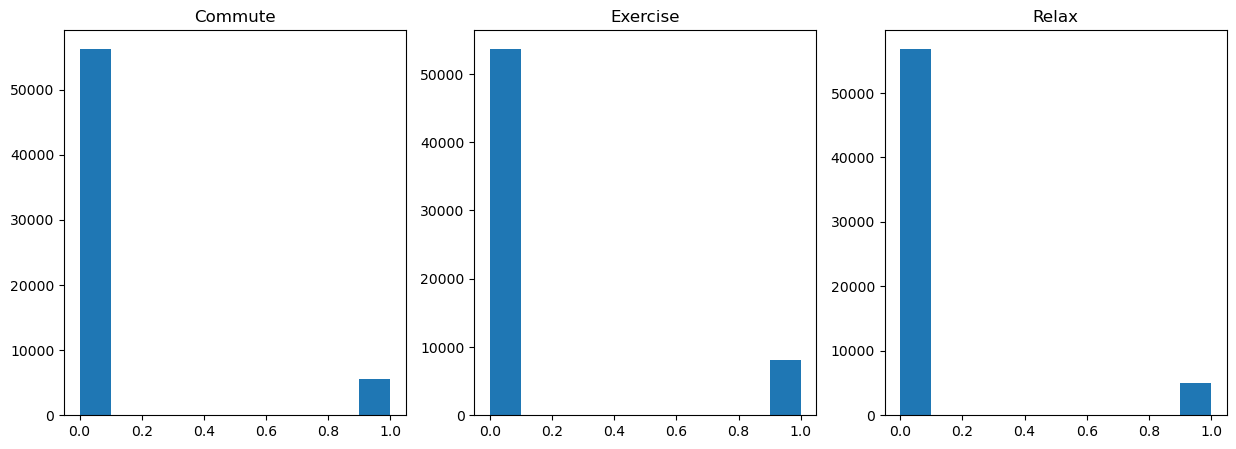

Commute:  0.08957686335403726
Exercise:  0.13122735507246377
Relax:  0.07995276915113872


In [ ]:
#checking for class imbalance with histograms
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(y_train['commute'])
ax[0].set_title('Commute')
ax[1].hist(y_train['exercise'])
ax[1].set_title('Exercise')
ax[2].hist(y_train['relax'])
ax[2].set_title('Relax')
plt.show()

#checking for class imbalance
print('Commute: ', np.sum(y_train['commute']) / len(y_train))
print('Exercise: ', np.sum(y_train['exercise']) / len(y_train))
print('Relax: ', np.sum(y_train['relax']) / len(y_train))




# Modeling

## Architecture

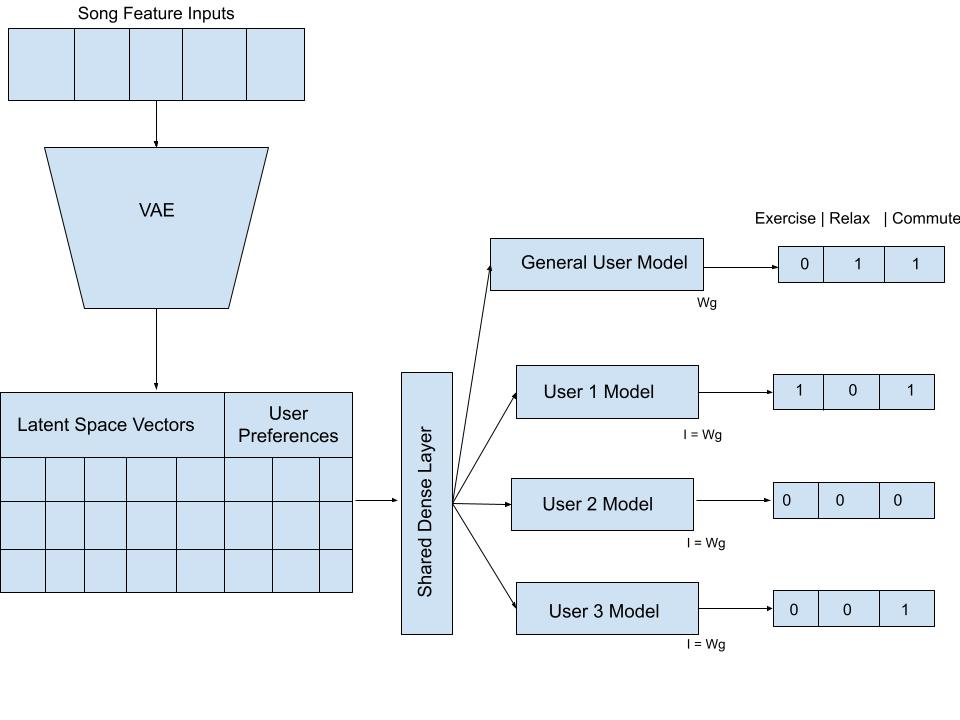

## Training a General Model

In [ ]:
#build a sequential model
general_classifier = Sequential()
general_classifier.add(layers.Dense(input_dim=latent_dim, units=12, activation='relu', name='shared_input_layer'))
general_classifier.add(layers.Dense(input_dim=latent_dim, units=9, activation='relu', name='mid_dense_9'))
general_classifier.add(layers.Dense(input_dim=latent_dim, units=7, activation='relu', name='mid_dense_7'))
general_classifier.add(layers.Dense(input_dim=latent_dim, units=3, activation='sigmoid', name='output_layer')) 

In [ ]:
gen_X_train = X_train.drop(columns=['user'])
gen_y_train = y_train.drop(columns=['user'])
gen_X_test = X_test.drop(columns=['user'])
gen_y_test = y_test.drop(columns=['user'])

#print the shape of the resulting sets
print("gen_X_train shape: ", gen_X_train.shape)
print("gen_y_train shape: ", gen_y_train.shape)
print("gen_X_test shape: ", gen_X_test.shape)
print("gen_y_test shape: ", gen_y_test.shape)

NameError: name 'X_train' is not defined

In [ ]:
class_weights = {}
for i in range(3):
    class_weights[i] = {}
    for j in range(2):
        class_count = np.sum(gen_y_train.iloc[:, i] == j)
        class_weights[i][j] = class_count/ len(gen_y_train.iloc[:, i])

class_weight_dict = {
    0: class_weights[0][0], 1: class_weights[0][1],
    2: class_weights[1][0], 3: class_weights[1][1],
    4: class_weights[2][0], 5: class_weights[2][1]
}

general_classifier.compile(optimizer='adam', loss='binary_crossentropy')
general_classifier.summary()
#train the model
general_classifier.fit(gen_X_train, gen_y_train, epochs=30, batch_size=32, class_weight=class_weight_dict, validation_data=(gen_X_test, gen_y_test))

NameError: name 'gen_y_train' is not defined

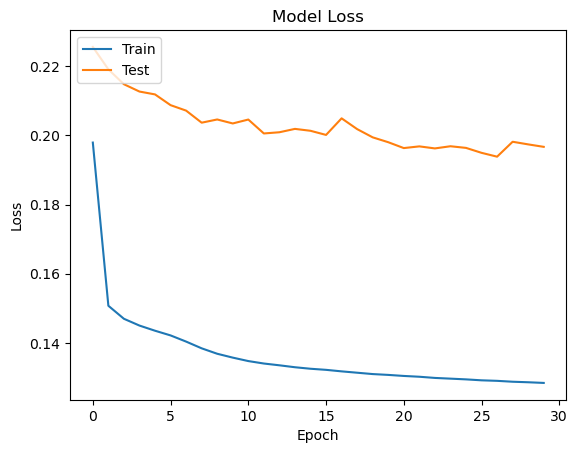

In [ ]:
#plot the loss
plt.plot(general_classifier.history.history['loss'])
plt.plot(general_classifier.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


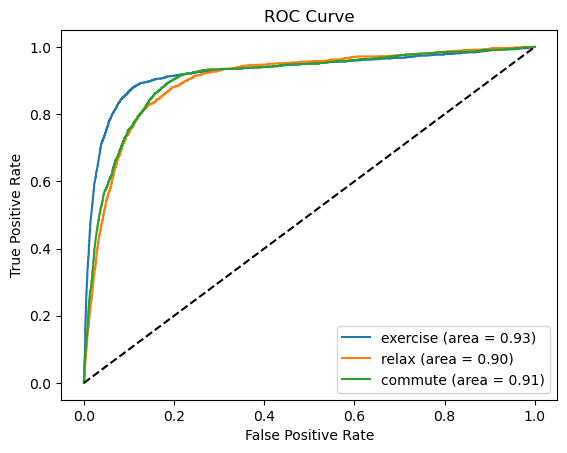

In [ ]:
#plot the auc roc curves for each activity
for i in range(3):
    y_pred = general_classifier.predict(gen_X_test, verbose=0)
    fpr, tpr, thresholds = roc_curve(gen_y_test.iloc[:, i], y_pred[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{} (area = {:.2f})'.format(gen_y_test.columns[i], auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
#print some random example predictions
for i in random.sample(range(len(gen_X_test)), 5):
    print('Predicted: ', general_classifier.predict(np.array([gen_X_test.iloc[i]]), verbose=0))
    print('Actual: ', np.array(gen_y_test.iloc[i]))
    print('')
        


Predicted:  [[0.01598609 0.00189763 0.05465012]]
Actual:  [0 0 0]

Predicted:  [[1.5403073e-02 3.2268558e-06 1.0231551e-02]]
Actual:  [0 0 0]

Predicted:  [[0.05778449 0.06820274 0.36041677]]
Actual:  [0 0 1]

Predicted:  [[1.7929977e-02 1.9764770e-05 6.0041705e-03]]
Actual:  [0 0 0]

Predicted:  [[0.68885994 0.08063491 0.22243145]]
Actual:  [1 0 1]



look at softmaxing the outputs

## Building a Multi Task Model

In [ ]:
#initializing weights
w1 = general_classifier.get_layer('shared_input_layer').get_weights()
w2 = general_classifier.get_layer('mid_dense_9').get_weights()
w3 = general_classifier.get_layer('mid_dense_7').get_weights()
w_output = general_classifier.get_layer('output_layer').get_weights()

#setting inputs
inputs = layers.Input(shape=(latent_dim,))
shared_input_layer = layers.Dense(12, activation='relu', name='shared_input_layer')(inputs)
shared_input_layer.set_weights(w1)

#dictionary for moodels for each user
user_models = {}

#get the number of user
users = users_data['user'].unique()

for user in users:

    mid_dense_9 = layers.Dense(9, activation='relu', name='mid_dense_9')(shared_input_layer)
    mid_dense_7 = layers.Dense(7, activation='relu', name='mid_dense_7')(mid_dense_9)
    output_layer = layers.Dense(3, activation='sigmoid', name='output_layer')(mid_dense_7)
    model = Model(inputs=inputs, outputs=output_layer)

    user_models[user] = model

    personal1 = user_models[user].get_layer('mid_dense_9')
    personal2 = user_models[user].get_layer('mid_dense_7')
    output = user_models[user].get_layer('output_layer')

    personal1.set_weights(w2)
    personal2.set_weights(w3)
    output.set_weights(w_output)
    
    personal1.trainable = True
    personal2.trainable = True
    output.trainable = True

In [ ]:
#creating dictionaries for my train and test sets whose keys are the user and values are the data
X_train_dict = dict()
y_train_dict = dict()
X_test_dict = dict()
y_test_dict = dict()

X_train_dict_df = dict()
y_train_dict_df = dict()
X_test_dict_df = dict()
y_test_dict_df = dict()

for user in y_train['user'].unique():
    X_train_dict_df[user] = X_train[y_train['user'] == user].drop(columns=['user'])
    y_train_dict_df[user] = y_train[y_train['user'] == user].drop(columns=['user'])
    X_test_dict_df[user] = X_test[y_test['user'] == user].drop(columns=['user'])
    y_test_dict_df[user] = y_test[y_test['user'] == user].drop(columns=['user'])


for user in y_train['user'].unique():
    X_train_dict[user] = X_train[y_train['user'] == user].drop(columns=['user']).values
    y_train_dict[user] = y_train[y_train['user'] == user].drop(columns=['user']).values
    X_test_dict[user] = X_test[y_test['user'] == user].drop(columns=['user']).values
    y_test_dict[user] = y_test[y_test['user'] == user].drop(columns=['user']).values

#print the shape of the train and test sets
for user in users:
    print('User: ', user)
    print('X_train shape: ', X_train_dict[user].shape)
    print('y_train shape: ', y_train_dict[user].shape)
    print('X_test shape: ', X_test_dict[user].shape)
    print('y_test shape: ', y_test_dict[user].shape)
    print('')

User:  2
X_train shape:  (20607, 12)
y_train shape:  (20607, 3)
X_test shape:  (5153, 12)
y_test shape:  (5153, 3)

User:  0
X_train shape:  (20608, 12)
y_train shape:  (20608, 3)
X_test shape:  (5152, 12)
y_test shape:  (5152, 3)

User:  1
X_train shape:  (20609, 12)
y_train shape:  (20609, 3)
X_test shape:  (5151, 12)
y_test shape:  (5151, 3)



In [ ]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from random import shuffle


def step(key_order, opt):
    # accumulate all the operations for the dataset
    preds = {} # each key will be a separate user
    loss = {}  # each key will be a separate user
    tapes = {} # each key will be a separate user
    single_loss = {}

    for x in key_order:
        with tf.GradientTape() as tape:
            tapes[x] = tape
            # make a prediction and calculate loss for each task
            preds[x] = user_models[x](X_train_dict[x])
            loss[x] = binary_crossentropy(y_train_dict[x], preds[x])
            single_loss[x] = binary_crossentropy(y_train_dict[x].ravel(), preds[x].numpy().ravel())
            
    # now batch update all the models with the gradients
    for x in key_order:
        grads = tapes[x].gradient(loss[x], user_models[x].trainable_variables)
        opt[x].apply_gradients(zip(grads, user_models[x].trainable_variables))

    y_all = np.concatenate([y_train_dict[x] for x in users]).ravel()
    yhat_all = np.concatenate([preds[x] for x in users]).ravel()

    single_loss['overall'] = binary_crossentropy(y_all, yhat_all)

    return single_loss


EPOCHS = 750

opt = {} # need separate optimizers for each output task
for x in users:
    opt[x] = Adam() # track 

train_losses = []
test_losses = []

for i in range(EPOCHS):
    print('Epoch',i,end=', ')
    shuffle(users) # shuffle in place operation, maybe not needed
    
    train_losses.append(step(users,opt)) # batched gradient updates

    y_mtl=[]
    yhat_mtl=[]

    valid_losses = {}
    for x in users:
        # test on data, for tracking
        yhat_mlp = user_models[x].predict(X_test_dict[x],verbose=0)
        y_mtl.append(y_test_dict[x].ravel())
        yhat_mtl.append(yhat_mlp.ravel())

        # calculate loss
        valid_losses[x] = binary_crossentropy(y_test_dict[x].ravel(), yhat_mlp.ravel())

    
    valid_losses['overall'] = binary_crossentropy(np.concatenate(y_mtl), np.concatenate(yhat_mtl))
    test_losses.append(valid_losses)

    print('Train loss:',np.array(train_losses[-1]['overall']),'Valid loss:',np.array(test_losses[-1]['overall']))

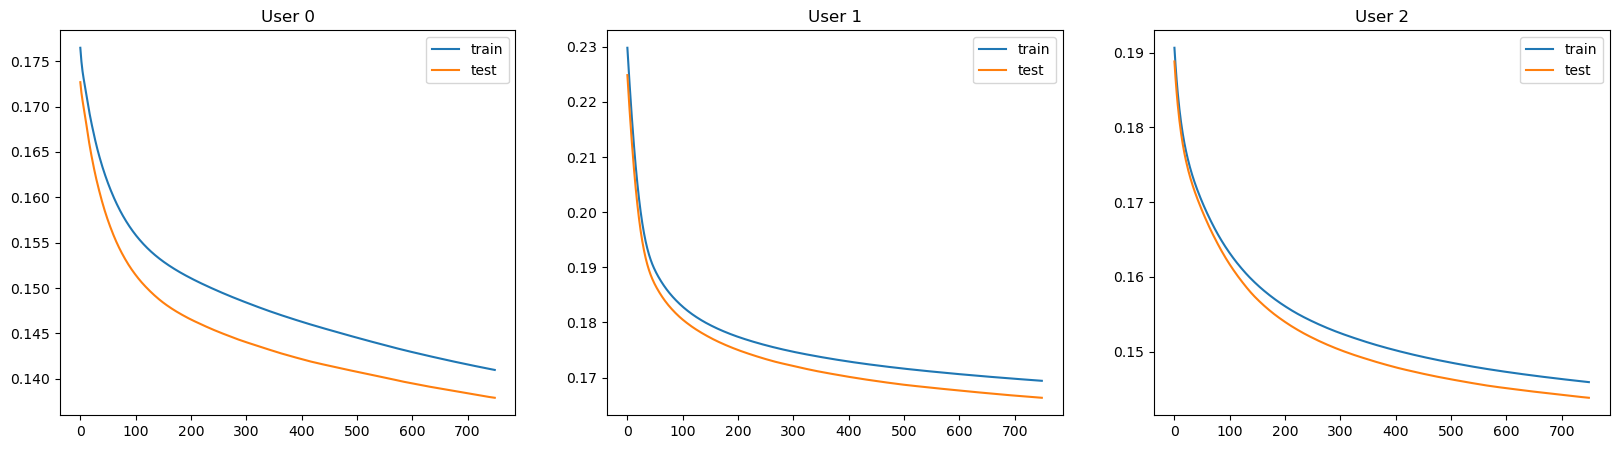

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for user in users:
    train_loss = [train_losses[j][user] for j in range(len(train_losses))]
    test_loss = [test_losses[j][user] for j in range(len(test_losses))]
    axs[user].plot(train_loss, label='train')
    axs[user].plot(test_loss, label='test')
    axs[user].set_title('User ' + str(user))
    axs[user].legend()

plt.show()


Both User 1 and User 2 seem to have trained to convergence while User 0 has not quite converged. This may be due to more difficult user preferences. My testing loss is also interestingly lower than my training loss.

## Model Fine-Tuning

Further training while freezing the shared layer to allow each individual model to further spcify into their own tasks without influencing the other tasks. Also initializing the learning rate lower to account for previous training and for further specificity.

In [ ]:
EPOCHS = 250

shared_input_layer.trainable = False

opt = {} # need separate optimizers for each output task
for x in users:
    opt[x] = Adam(learning_rate=1e-4) # track 

train_losses = []
test_losses = []

for i in range(EPOCHS):
    print('Epoch',i,end=', ')
    shuffle(users) # shuffle in place operation, maybe not needed
    
    train_losses.append(step(users,opt)) # batched gradient updates

    y_mtl=[]
    yhat_mtl=[]

    valid_losses = {}
    for x in users:
        # test on data, for tracking
        yhat_mlp = user_models[x].predict(X_test_dict[x],verbose=0)
        y_mtl.append(y_test_dict[x].ravel())
        yhat_mtl.append(yhat_mlp.ravel())

        # calculate loss
        valid_losses[x] = binary_crossentropy(y_test_dict[x].ravel(), yhat_mlp.ravel())

    
    valid_losses['overall'] = binary_crossentropy(np.concatenate(y_mtl), np.concatenate(yhat_mtl))
    test_losses.append(valid_losses)

    print('Train loss:',np.array(train_losses[-1]['overall']),'Valid loss:',np.array(test_losses[-1]['overall']))

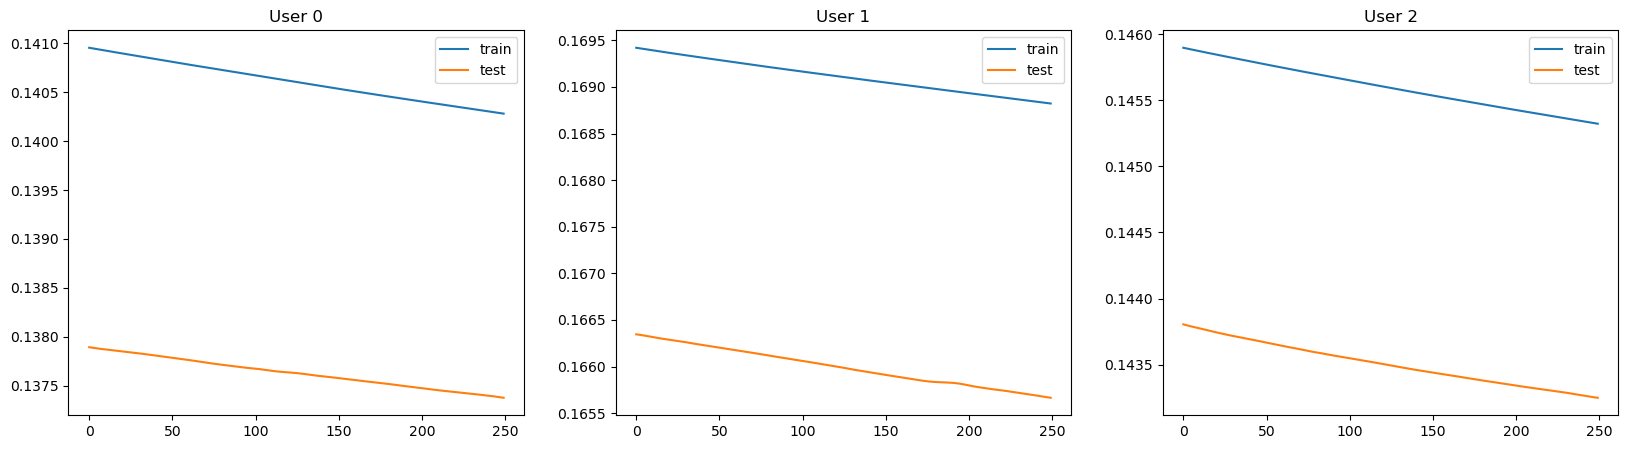

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for user in users:
    train_loss = [train_losses[j][user] for j in range(len(train_losses))]
    test_loss = [test_losses[j][user] for j in range(len(test_losses))]
    axs[user].plot(train_loss, label='train')
    axs[user].plot(test_loss, label='test')
    axs[user].set_title('User ' + str(user))
    axs[user].legend()

plt.show()


After fine tuning and training for 250 more epochs, the losses are steaily decreading but the differences are so small so I dont think that further training will lead to significant model improvement. This may be becuase I initialized the learning rate very low, if the learning rate was greater, the model loss may have decreased more.

# Results

161/161 [==============================] - 0s 2ms/step


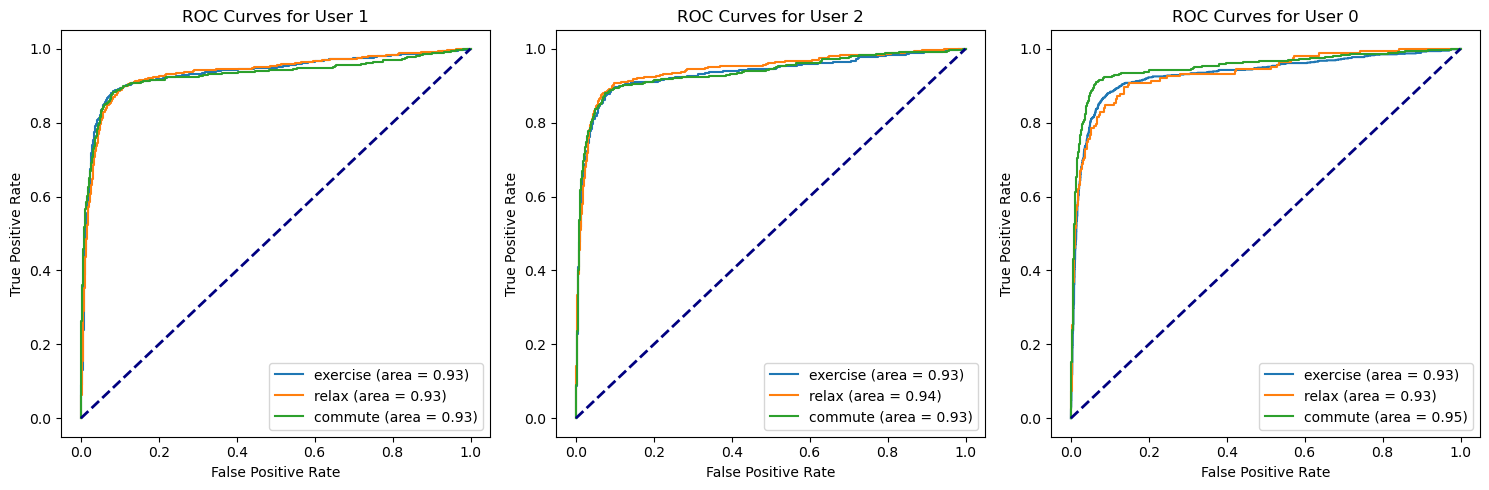

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=len(users), figsize=(15, 5))

for i, user in enumerate(users):
    # make predictions on test data
    y_pred = user_models[user].predict(X_test_dict[user])

    # loop over output nodes
    for j in range(y_test_dict[user].shape[1]):
        # calculate ROC curve and AUC score
        fpr, tpr, thresholds = roc_curve(y_test_dict[user][:, j], y_pred[:, j])
        auc_score = auc(fpr, tpr)

        # plot ROC curve
        axes[i].plot(fpr, tpr, label='{} (area = {:.2f})'.format(y_test_dict_df[user].columns[j], auc_score))

    # set plot title, legend, and axis labels
    axes[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[i].set_title('ROC Curves for User {}'.format(user))
    axes[i].legend()
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')

# adjust spacing between plots
plt.tight_layout()

# show plots
plt.show()


161/161 [==============================] - 0s 610us/step


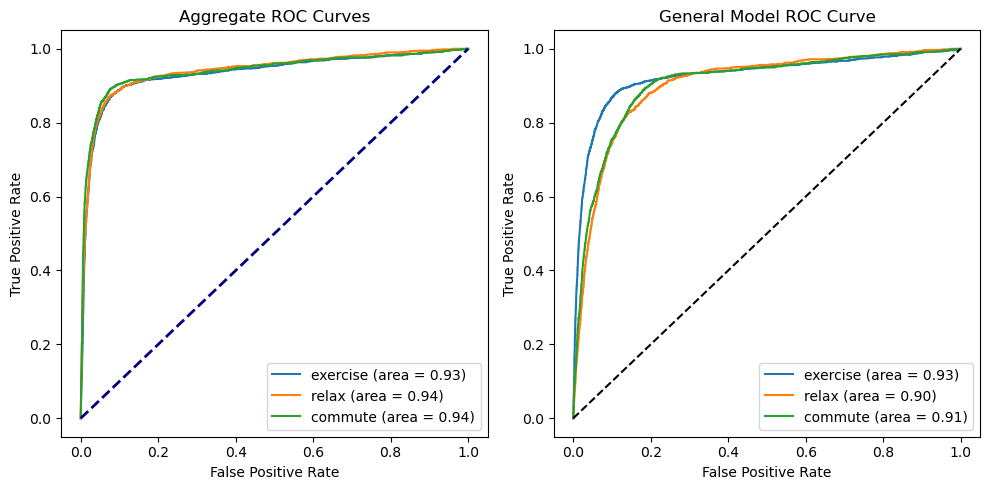

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# plot the aggregate ROC curve on the first subplot
for j in range(y_test_dict[user].shape[1]):
    fpr, tpr, thresholds = roc_curve(np.concatenate([y_test_dict[x][:, j] for x in users]), np.concatenate([user_models[x].predict(X_test_dict[x])[:, j] for x in users]))
    auc_score = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, label='{} (area = {:.2f})'.format(y_test_dict_df[user].columns[j], auc_score))
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_title('Aggregate ROC Curves')
axes[0].legend()
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')

# plot the ROC curves for each activity on the second subplot
for i in range(3):
    y_pred = general_classifier.predict(gen_X_test, verbose=0)
    fpr, tpr, thresholds = roc_curve(gen_y_test.iloc[:, i], y_pred[:, i])
    auc_score = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, label='{} (area = {:.2f})'.format(gen_y_test.columns[i], auc_score))
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('General Model ROC Curve')
axes[1].legend(loc='lower right')

# adjust spacing between subplots
plt.tight_layout()

# show plot
plt.show()


When analyzing the results, we see that the auc scores with the multi-task model exceed the auc scores of the general model. This means that in general, the multi-task model is better at distinguishing between positive and negative classes.<br><br>

When breaking down each individual user (task) we see that the model performed slightly better for users 2 and 1 than it did for user 0. When we look at the auc scores for exercise, we see that all of the models including the general model, were the same with an auc score of .93. The relax and commute activities is where the scores are distinguished. For relaxing, the general model performed the worst with an auc of .90 while the multi-task model had an auc score of .93 for users 0 and 2 and an auc score of .94 for user 1. When observing the commute activity, the general model performs the worst with an auc score of .91 while the multi-task model had an auc score of .93 for users 1 and 2 and an auc score of .95 for user 0.

In [ ]:
auc_table = pd.DataFrame(columns=['User ' + str(user) for user in users]+['General Model'], index=gen_y_test.columns)

for i, user in enumerate(users):
    y_pred = user_models[user].predict(X_test_dict[user], verbose=0)
    for j in range(gen_y_test.shape[1]):
        fpr, tpr, thresholds = roc_curve(y_test_dict[user][:, j], y_pred[:, j])
        auc_table.loc[auc_table.index[j], 'User ' + str(user)] = auc(fpr, tpr)

y_pred = general_classifier.predict(gen_X_test, verbose=0)
for j in range(gen_y_test.shape[1]):
    fpr, tpr, thresholds = roc_curve(gen_y_test.iloc[:, j], y_pred[:, j])
    auc_table.loc[auc_table.index[j], 'General Model'] = auc(fpr, tpr)

# highlight the highest AUC score for each activity
auc_table = auc_table.style.apply(lambda x: ['font-weight: bold' if i == x.values.max() else '' for i in x], axis=1)
auc_table


,User 1,User 2,User 0,General Model
exercise,0.933783,0.932013,0.931465,0.925727
relax,0.933676,0.942112,0.933063,0.902224
commute,0.928222,0.934272,0.950776,0.905493


# Further Analysis

In order to further analyze my model, I will see how it performs if I regenerate the user preferences with more randomness. My initial users were generated with 10% randomness and now i will generate them with 20% randomness. I thing this is a useful analysis to see how my recommender performs wfor user with more eclectic tastes. In a real world scenario, a user's tastes vary, I want to see how my model performs with users who have more varied tastes.

In [ ]:
users_data_2 = create_users(num_users=3, randomness_percent=.2, centroid_radius=1, random_radius=None)
users_data_2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,user,exercise,relax,commute
0,-0.019045,-0.004042,-0.002079,-0.016153,0.011946,0.014009,-0.017742,-0.064353,-0.853226,0.007500,0.019189,-0.675159,0,1,0,0
1,0.000837,0.021853,0.029185,-0.010078,0.015006,0.013867,-0.022846,0.835102,0.973189,-0.010224,-0.000900,0.000459,0,0,0,0
2,-0.027470,0.004121,0.011886,-0.016978,0.016231,0.019297,-0.022057,0.655998,0.113187,0.006594,0.016998,-1.024455,0,0,0,0
3,0.015544,0.024992,0.026014,-0.035301,0.054430,0.002618,-0.031899,0.835129,1.105639,-0.031586,0.000543,0.920656,0,1,0,0
4,0.012051,0.015835,0.017753,-0.020172,0.021802,0.028320,-0.035633,0.509528,0.055178,0.005396,-0.000039,0.524336,0,0,0,0


In [ ]:
#train test split with validation set
X_2 = users_data_2.drop(columns=['exercise', 'relax', 'commute'])
y_2 = users_data_2[['user', 'exercise', 'relax', 'commute']]

# split the data into training and test sets with stratification over user, exercise, relax, and commute
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42, stratify=users_data_2[['user', 'exercise', 'relax', 'commute']])

# print the shape of the resulting sets
print("X_train shape: ", X_train_2.shape)
print("y_train shape: ", y_train_2.shape)
print("X_test shape: ", X_test_2.shape)
print("y_test shape: ", y_test_2.shape)

X_train shape:  (61824, 13)
y_train shape:  (61824, 4)
X_test shape:  (15456, 13)
y_test shape:  (15456, 4)


In [ ]:
#build a sequential model
general_classifier_2 = Sequential()
general_classifier_2.add(layers.Dense(input_dim=latent_dim, units=12, activation='relu', name='shared_input_layer'))
general_classifier_2.add(layers.Dense(input_dim=latent_dim, units=9, activation='relu', name='mid_dense_9'))
general_classifier_2.add(layers.Dense(input_dim=latent_dim, units=7, activation='relu', name='mid_dense_7'))
general_classifier_2.add(layers.Dense(input_dim=latent_dim, units=3, activation='sigmoid', name='output_layer')) 

gen_X_train_2 = X_train_2.drop(columns=['user'])
gen_y_train_2 = y_train_2.drop(columns=['user'])
gen_X_test_2 = X_test_2.drop(columns=['user'])
gen_y_test_2 = y_test_2.drop(columns=['user'])

#print the shape of the resulting sets
print("gen_X_train shape: ", gen_X_train_2.shape)
print("gen_y_train shape: ", gen_y_train_2.shape)
print("gen_X_test shape: ", gen_X_test_2.shape)
print("gen_y_test shape: ", gen_y_test_2.shape)

class_weights_2 = {}
for i in range(3):
    class_weights_2[i] = {}
    for j in range(2):
        class_count_2 = np.sum(gen_y_train_2.iloc[:, i] == j)
        class_weights_2[i][j] = class_count_2/ len(gen_y_train_2.iloc[:, i])

class_weight_dict_2 = {
    0: class_weights_2[0][0], 1: class_weights_2[0][1],
    2: class_weights_2[1][0], 3: class_weights_2[1][1],
    4: class_weights_2[2][0], 5: class_weights_2[2][1]
}

general_classifier_2.compile(optimizer='adam', loss='binary_crossentropy')
general_classifier_2.summary()
#train the model
general_classifier_2.fit(gen_X_train_2, gen_y_train_2, epochs=30, batch_size=32, class_weight=class_weight_dict_2, validation_data=(gen_X_test_2, gen_y_test_2))

gen_X_train shape:  (61824, 12)
gen_y_train shape:  (61824, 3)
gen_X_test shape:  (15456, 12)
gen_y_test shape:  (15456, 3)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared_input_layer (Dense)  (None, 12)                156       
                                                                 
 mid_dense_9 (Dense)         (None, 9)                 117       
                                                                 
 mid_dense_7 (Dense)         (None, 7)                 70        
                                                                 
 output_layer (Dense)        (None, 3)                 24        
                                                                 
Total params: 367
Trainable params: 367
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1932/1932 [==============================] - 2s 1ms/s

In [ ]:
#initializing weights
w1 = general_classifier_2.get_layer('shared_input_layer').get_weights()
w2 = general_classifier_2.get_layer('mid_dense_9').get_weights()
w3 = general_classifier_2.get_layer('mid_dense_7').get_weights()
w_output = general_classifier_2.get_layer('output_layer').get_weights()

#setting inputs
inputs = layers.Input(shape=(latent_dim,))
shared_input_layer = layers.Dense(12, activation='relu', name='shared_input_layer')(inputs)

#dictionary for moodels for each user
user_models = {}

#get the number of user
users = users_data['user'].unique()

for user in users:

    mid_dense_9 = layers.Dense(9, activation='relu', name='mid_dense_9')(shared_input_layer)
    mid_dense_7 = layers.Dense(7, activation='relu', name='mid_dense_7')(mid_dense_9)
    output_layer = layers.Dense(3, activation='sigmoid', name='output_layer')(mid_dense_7)
    model = Model(inputs=inputs, outputs=output_layer)

    user_models[user] = model

    personal1 = user_models[user].get_layer('mid_dense_9')
    personal2 = user_models[user].get_layer('mid_dense_7')
    output = user_models[user].get_layer('output_layer')

    personal1.set_weights(w2)
    personal2.set_weights(w3)
    output.set_weights(w_output)
    
    personal1.trainable = True
    personal2.trainable = True
    output.trainable = True

In [ ]:
#creating dictionaries for my train and test sets whose keys are the user and values are the data
X_train_dict = dict()
y_train_dict = dict()
X_test_dict = dict()
y_test_dict = dict()

X_train_dict_df = dict()
y_train_dict_df = dict()
X_test_dict_df = dict()
y_test_dict_df = dict()

for user in y_train['user'].unique():
    X_train_dict_df[user] = X_train[y_train['user'] == user].drop(columns=['user'])
    y_train_dict_df[user] = y_train[y_train['user'] == user].drop(columns=['user'])
    X_test_dict_df[user] = X_test[y_test['user'] == user].drop(columns=['user'])
    y_test_dict_df[user] = y_test[y_test['user'] == user].drop(columns=['user'])


for user in y_train['user'].unique():
    X_train_dict[user] = X_train[y_train['user'] == user].drop(columns=['user']).values
    y_train_dict[user] = y_train[y_train['user'] == user].drop(columns=['user']).values
    X_test_dict[user] = X_test[y_test['user'] == user].drop(columns=['user']).values
    y_test_dict[user] = y_test[y_test['user'] == user].drop(columns=['user']).values

#print the shape of the train and test sets
for user in users:
    print('User: ', user)
    print('X_train shape: ', X_train_dict[user].shape)
    print('y_train shape: ', y_train_dict[user].shape)
    print('X_test shape: ', X_test_dict[user].shape)
    print('y_test shape: ', y_test_dict[user].shape)
    print('')

User:  0
X_train shape:  (20608, 12)
y_train shape:  (20608, 3)
X_test shape:  (5152, 12)
y_test shape:  (5152, 3)

User:  1
X_train shape:  (20609, 12)
y_train shape:  (20609, 3)
X_test shape:  (5151, 12)
y_test shape:  (5151, 3)

User:  2
X_train shape:  (20607, 12)
y_train shape:  (20607, 3)
X_test shape:  (5153, 12)
y_test shape:  (5153, 3)



In [ ]:
EPOCHS = 1000

opt = {} # need separate optimizers for each output task
for x in users:
    opt[x] = Adam() # track 

train_losses = []
test_losses = []

for i in range(EPOCHS):
    
    if EPOCHS == 750: shared_input_layer_2.trainable = False

    print('Epoch',i,end=', ')
    shuffle(users) # shuffle in place operation, maybe not needed
    
    train_losses.append(step(users,opt)) # batched gradient updates

    y_mtl=[]
    yhat_mtl=[]

    valid_losses = {}
    for x in users:
        # test on data, for tracking
        yhat_mlp = user_models[x].predict(X_test_dict[x],verbose=0)
        y_mtl.append(y_test_dict[x].ravel())
        yhat_mtl.append(yhat_mlp.ravel())

        # calculate loss
        valid_losses[x] = binary_crossentropy(y_test_dict[x].ravel(), yhat_mlp.ravel())

    
    valid_losses['overall'] = binary_crossentropy(np.concatenate(y_mtl), np.concatenate(yhat_mtl))
    test_losses.append(valid_losses)

    print('Train loss:',np.array(train_losses[-1]['overall']),'Valid loss:',np.array(test_losses[-1]['overall']))

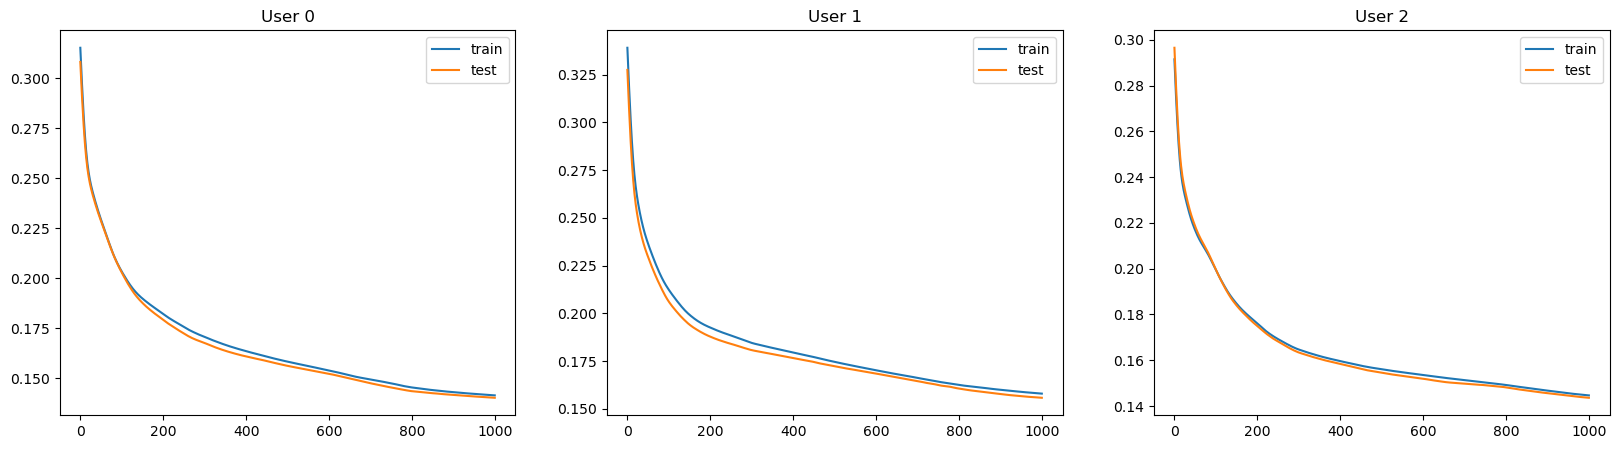

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for user in users:
    train_loss = [train_losses[j][user] for j in range(len(train_losses))]
    test_loss = [test_losses[j][user] for j in range(len(test_losses))]
    axs[user].plot(train_loss, label='train')
    axs[user].plot(test_loss, label='test')
    axs[user].set_title('User ' + str(user))
    axs[user].legend()

plt.show()

162/162 [==============================] - 0s 589us/step


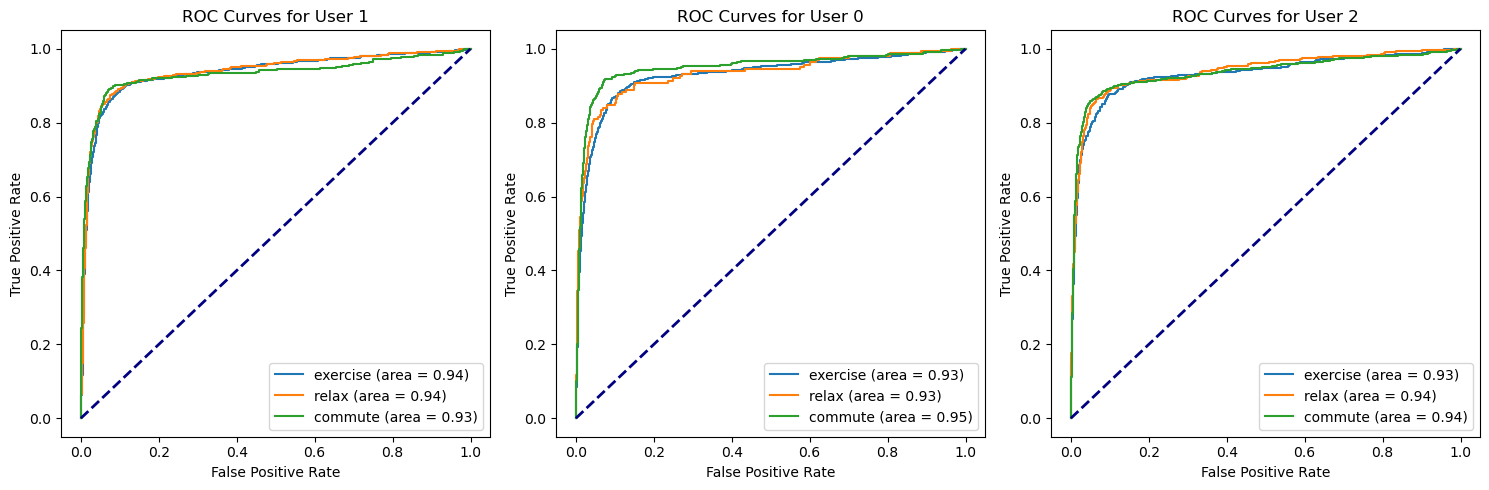

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=len(users), figsize=(15, 5))

for i, user in enumerate(users):
    # make predictions on test data
    y_pred = user_models[user].predict(X_test_dict[user])

    # loop over output nodes
    for j in range(y_test_dict[user].shape[1]):
        # calculate ROC curve and AUC score
        fpr, tpr, thresholds = roc_curve(y_test_dict[user][:, j], y_pred[:, j])
        auc_score = auc(fpr, tpr)

        # plot ROC curve
        axes[i].plot(fpr, tpr, label='{} (area = {:.2f})'.format(y_test_dict_df[user].columns[j], auc_score))

    # set plot title, legend, and axis labels
    axes[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[i].set_title('ROC Curves for User {}'.format(user))
    axes[i].legend()
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')

# adjust spacing between plots
plt.tight_layout()

# show plots
plt.show()

The auc scores for this model with twice the randomness are almost the same as the scores in my previous model. This is a good sign that my model generalizes well to different user preferences. It would be interesting to train my model with varyiing randomness among the users to see how it performs with different types of users trained together.

In [ ]:
#export this notebook to html
!jupyter nbconvert --to html /Users/eliasmann/Documents/contextRec/Lab2_multi_task_modal.ipynb



[NbConvertApp] Converting notebook /Users/eliasmann/Documents/contextRec/Lab2_multi_task_modal.ipynb to html
/Users/eliasmann/opt/anaconda3/envs/newMlEnv/lib/python3.10/site-packages/nbconvert/filters/widgetsdatatypefilter.py:71: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.plotly.v1+json']) is not able to be represented.
  warn(
[NbConvertApp] Writing 2754965 bytes to /Users/eliasmann/Documents/contextRec/Lab2_multi_task_modal.html
